In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train_data =  pd.read_csv("/content/train.csv")
validation_data =  pd.read_csv("/content/validation.csv")
data = pd.concat([train_data , validation_data])
test =  pd.read_csv("/content/test.csv")

In [3]:
pip install transformers

In [4]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [5]:
data.head()

,review,sentiment
0,Aditya Ingole Deaf,2
1,I love the app.! There is no issue but if u co...,1
2,"So hard to use. The web app failed, and the mo...",0
3,I hate that the app makes a sound every time s...,1
4,Useless at BSE star MF meet.voice too mych slo...,0


In [6]:
data.count()

review       38492
sentiment    38492
dtype: int64

In [7]:
data["sentiment"].value_counts()

2    14537
0    12792
1    11163
Name: sentiment, dtype: int64

In [8]:
dff=[len(i.split(" ")) for i in data.review[:100]]
max(dff)

85

In [9]:
# dff

In [10]:
data.review[:15]

0                                    Aditya Ingole Deaf
1     I love the app.! There is no issue but if u co...
2     So hard to use. The web app failed, and the mo...
3     I hate that the app makes a sound every time s...
4     Useless at BSE star MF meet.voice too mych slo...
5      همه شون مسخره اند به مولا قسم ایتز اوکیوووو کوفت
6                                        I love you app
7     paki lagay naman po nito katulad sa computer l...
8                                                  Good
9     I have some complain about this app, whenever ...
10    It is a good application but I can't joint to ...
11    Very disappointed to know that Zoom virtual ba...
12    Its so hackable by the gov. Or docs. And any h...
13    I like the mobility the app provides. however,...
14                                       Close my class
Name: review, dtype: object

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.sentiment.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=data.sentiment)

data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'


In [12]:
X_train

array([ 1649, 18659, 24991, ...,  1631, 14384, 23358])

In [13]:
# Name of the BERT model to use
model_name = 'bert-base-cased'

# Max length of tokens
max_length = max(dff)+3

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)



In [14]:
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert = TFAutoModel.from_pretrained('bert-base-cased')
embeddings = bert.bert(inputs)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
x =Dense(1024, activation='relu')(embeddings)
y =Dense(3, activation='softmax', name='outputs')(x)

model = Model(inputs=inputs, outputs=y)
#model.layers[2].trainable = False

# Take a look at the model
model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 88)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 88)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 88,                                            

In [15]:
y_senti = to_categorical(data[data.data_type=='train'].sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='train'].review.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

train=tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
def map_func(input_ids, masks, labels):
    # convert three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

train = train.map(map_func)
batch_size = 32

# shuffle and batch - dropping any remaining samples that don't cleanly
train = train.shuffle(100).batch(batch_size, drop_remainder=True)

In [16]:
y_senti

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [17]:
train.take(1)

<TakeDataset shapes: ({input_ids: (32, 88), attention_mask: (32, 88)}, (32, 3)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float32)>

In [18]:
y_senti = to_categorical(data[data.data_type=='val'].sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='val'].review.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

val = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
val = val.map(map_func)
val = val.shuffle(100).batch(batch_size, drop_remainder=True)

In [19]:
optimizer = Adam(lr=1e-5, decay=1e-6)
loss = CategoricalCrossentropy()
acc = CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# Fit the model
history = model.fit(
    train,
    validation_data = val,
    epochs = 5)

Epoch 1/5
1007/1007 [==============================] - 1465s 1s/step - loss: 0.8122 - accuracy: 0.6234 - val_loss: 0.7712 - val_accuracy: 0.6503
Epoch 2/5
1007/1007 [==============================] - 1448s 1s/step - loss: 0.6963 - accuracy: 0.6927 - val_loss: 0.7399 - val_accuracy: 0.6811
Epoch 3/5
1007/1007 [==============================] - 1453s 1s/step - loss: 0.5834 - accuracy: 0.7549 - val_loss: 0.7344 - val_accuracy: 0.7011
Epoch 4/5
1007/1007 [==============================] - 1460s 1s/step - loss: 0.4667 - accuracy: 0.8140 - val_loss: 0.7607 - val_accuracy: 0.7212
Epoch 5/5
1007/1007 [==============================] - 1463s 1s/step - loss: 0.3798 - accuracy: 0.8515 - val_loss: 0.8218 - val_accuracy: 0.7345


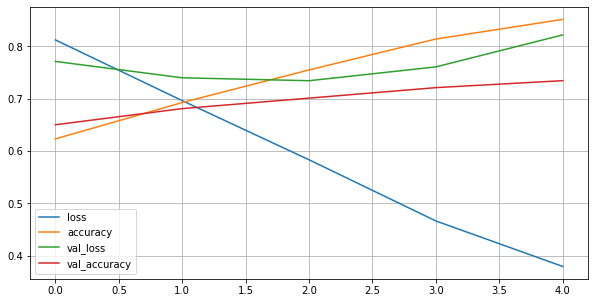

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

learning_data = pd.DataFrame(history.history)
# learning_data.head()
learning_data.plot(figsize=(10,5))
plt.grid(True)
plt.show()

In [21]:
model.save('./sentiment-analysis-on-movie-reviews/sentiment_model')

INFO:tensorflow:Assets written to: ./sentiment-analysis-on-movie-reviews/sentiment_model/assets


INFO:tensorflow:Assets written to: ./sentiment-analysis-on-movie-reviews/sentiment_model/assets


In [22]:
#model = tf.keras.models.load_model('./sentiment-analysis-on-movie-reviews/sentiment_model')
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [25]:
model.save('my_model.h5')

In [26]:
# # Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('my_model.h5')

# # Show the model architecture
# new_model.summary()

In [27]:
test.shape[0]

2026

In [38]:
test

,review,sentiment
0,Very misleading not user friendly,0
1,Malik,1
2,"Video, Voice, Usability, Uncluttered, Chic!!!...",2
3,It s not working hayzzz,0
4,#4200Gujarat,0
...,...,...
2021,Aa,1
2022,This app drops and freezes a lot during meetings.,0
2023,Extremely effective tool very easy controls An...,2
2024,Ok,2


In [28]:
x = tokenizer(
    text=test.review.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [29]:
x

{'input_ids': <tf.Tensor: shape=(2026, 88), dtype=int32, numpy=
array([[  101,  6424, 25175, ...,     0,     0,     0],
       [  101, 15147,   102, ...,     0,     0,     0],
       [  101,  6301,   117, ...,     0,     0,     0],
       ...,
       [  101, 19005,  1193, ...,     0,     0,     0],
       [  101, 23330,   102, ...,     0,     0,     0],
       [  101, 25120, 12647, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2026, 88), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [30]:
items=tf.data.Dataset.from_tensor_slices((x['input_ids'],x['attention_mask']))

In [31]:
items

<TensorSliceDataset shapes: ((88,), (88,)), types: (tf.int32, tf.int32)>

In [32]:
def map_func(input_ids, masks):
    return {'input_ids': input_ids, 'attention_mask': masks}

items = items.map(map_func)
items = items.batch(32)

In [33]:
items

<BatchDataset shapes: {input_ids: (None, 88), attention_mask: (None, 88)}, types: {input_ids: tf.int32, attention_mask: tf.int32}>

In [34]:
predictions=model.predict(items).argmax(axis=-1)

In [36]:
len(predictions)

2026

In [37]:
predictions

array([0, 1, 2, ..., 2, 2, 0])

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions , test.sentiment )
cm

array([[538, 102,  41],
       [ 89, 373,  91],
       [ 47, 112, 633]])

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test.sentiment, predictions))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       674
           1       0.67      0.64      0.65       587
           2       0.80      0.83      0.81       765

    accuracy                           0.76      2026
   macro avg       0.75      0.75      0.75      2026
weighted avg       0.76      0.76      0.76      2026



In [ ]:
submission = pd.DataFrame()
submission['PhraseId'] = test['PhraseId']
submission['Sentiment'] = predictions
submission.to_csv("submission.csv", index=False)